## ggplottree function

In [75]:
library("ape")
library(RColorBrewer)
library(dplyr)
library('ggplot2')
library('ggtree')
library(tidytree)
library(ggnewscale)

In [11]:
gettreedata <- function(tree, meta){
    d<-meta[row.names(meta) %in% tree$tip.label,]
    d$label <- row.names(d)
    y <- full_join(as_tibble(tree), d, by='label')
    y <- as.treedata(y)
    return(y)
}

get_color_mapping <- function(data, col, cmap){
    labels <- (data[[col]])   
    names <- levels(as.factor(labels)) 
    n <- length(names)
    if (n<10){      
        colors <- suppressWarnings(c(brewer.pal(n, cmap)))[1:n]
    }
    else {
        colors <- colorRampPalette(brewer.pal(8, cmap))(n)
    }
    names(colors) = names
    return (colors)
}

#' @title ggplottree
#' @description  convenvience function for ggtree drawing
#' @param tree R ape tree
#' @param meta metadata for coloring and labels, an R data.frame
#' @param cols name of color column(s) as list
#' @return ggtree
#' @examples
#' # Example of how to use the function
#' p <- ggplottree(tree, meta, layout='rect', cols=c('label'), cmaps=c('Set1'),offset=.02,
#'           tipsize=4, tiplabel=TRUE, tiplabelsize=4)
#' @export
ggplottree <- function(tree, meta, cols=NULL, colors=NULL, cmaps=NULL, layout="rectangular",
                       offset=10, tiplabel=FALSE, tipsize=3, tiplabelsize=5, tiplabelcol=NULL,
					   align=FALSE, tipoffset=0) {
    
    y <- gettreedata(tree, meta)
    if (layout == 'cladogram'){
        p <- ggtree(y, layout='c', branch.length='none')
    }
    else {
        p <- ggtree(y, layout=layout)
    }
    
    if (is.null(cols)) { 
        if (tiplabel){
            p <- p + geom_tiplab(size=tiplabelsize,offset=tipoffset) 
        }
        return (p)
    }
    col <- cols[1] 
    if (!is.null(colors)) {
        #use predefined colors
        clrs <- colors
    }
    else {
        #calculate colors from cmap        
        cmap <- cmaps[1]
        df <- meta[tree$tip.label,][col]
        clrs <- get_color_mapping(df, col, cmap)
    } 
    #print (clrs)
    p <- p + new_scale_fill() + 
            geom_tippoint(mapping=aes(fill=.data[[col]]),size=tipsize,shape=21,stroke=0) +
            scale_fill_manual(values=clrs, na.value="black")
              
    p2 <- p
    if (length(cols)>1){
        for (i in 2:length(cols)){
            col <- cols[i]
            if (length(cmaps)>=i){
                cmap <- cmaps[i]
            }
            else {
                cmap = 'Greys'
            }
            df <- meta[tree$tip.label,][col]
            type <- class(df[col,])
            print (type)
            p2 <- p2 + new_scale_fill()
            p2 <- gheatmap(p2, df, offset=i*offset, width=.08,
                      colnames_angle=0, colnames_offset_y = .05)            
            if (type %in% c('numeric','integer')){
				p2 <- p2 + scale_fill_gradient(low='#F8F699',high='#06A958', na.value="white")
            }
            else {
                colors <- get_color_mapping(df, col, cmap)
                p2 <- p2 + scale_fill_manual(values=colors, name=col, na.value="white")
            }          
        }
    }
    
    p2 <- p2 + theme_tree2(legend.text = element_text(size=20), legend.key.size = unit(1, 'cm'), 
                        legend.position="left", plot.title = element_text(size=40))     
            guides(color = guide_legend(override.aes = list(size=10))) 
    if (tiplabel) {
		if (!is.null(tiplabelcol)) {
			p2 <- p2 + geom_tiplab(mapping=aes(label=.data[[tiplabelcol]]), 
								size=tiplabelsize, align=align,offset=tipoffset)
		} 
		else {
        	p2 <- p2 + geom_tiplab(size=tiplabelsize, align=align,offset=tipoffset) 		
		}
    }     
    return(p2)
}

In [54]:
# Function to generate a random tree with n tips
generate_tree <- function(n) {
  # Generate the tree using rtree function
  tree <- rtree(n)  
  # Generate tip labels from A-Z, then AA, AB, etc. if n > 26
  generate_labels <- function(n) {
    letters <- c(LETTERS, sapply(LETTERS, function(x) paste0(x, LETTERS)))
    return(letters[1:n])
  }  
  tip_labels <- generate_labels(n)  
  # Assign the generated tip labels to the tree
  tree$tip.label <- tip_labels  
  return(tree)
}

In [68]:
generate_metadata <- function(tip_labels) {
 
  species <- c("Cow", "Sheep", "Deer")
  countries <- c("Ireland", "UK")
  n <- length(tip_labels)
  # Create a data.frame with random metadata
  metadata <- data.frame(
    species = sample(species, n, replace = TRUE),
    year = sample(2000:2020, n, replace = TRUE),
    country = sample(countries, n, replace = TRUE),
    label = sample(c('X','Y'), n, replace=TRUE),
    label2 = sample(c('A','B','C'), n, replace=TRUE) 
  )  
  # Add the tip labels as the first column
  rownames(metadata)<-tip_labels  
  return(metadata)
}

In [79]:
tree<-generate_tree(25)
df <- generate_metadata(tree$tip.label)

[1] "character"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


[1] "integer"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


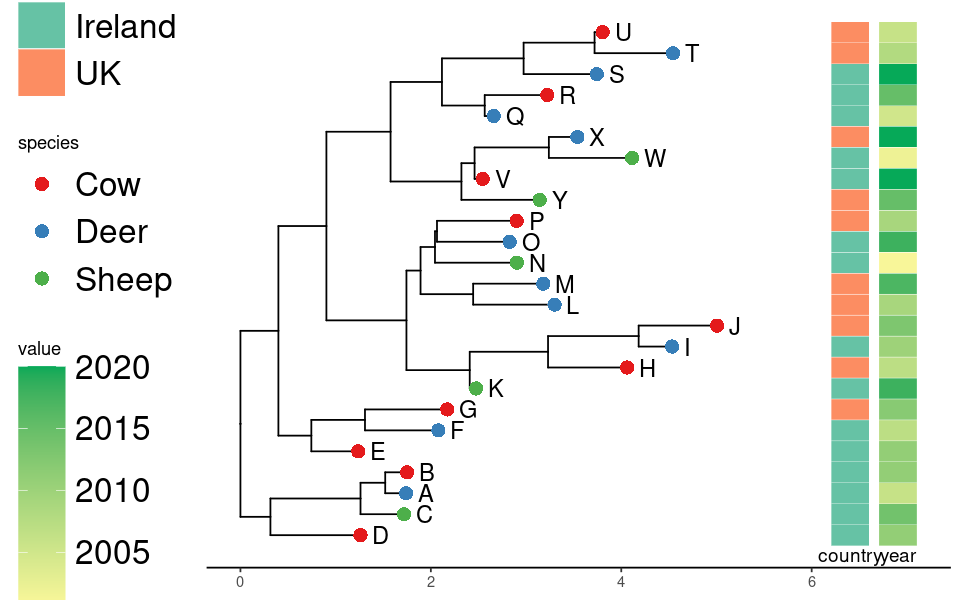

In [80]:
options(repr.plot.width=8, repr.plot.height=5)
ggplottree(tree, df, layout='rect', cols=c('species','country','year'),
           cmaps=c('Set1','Set2','Blues'), tiplabel=TRUE, tipoffset=.1, tipsize=4, offset=.5)

[1] "character"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


[1] "character"


Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


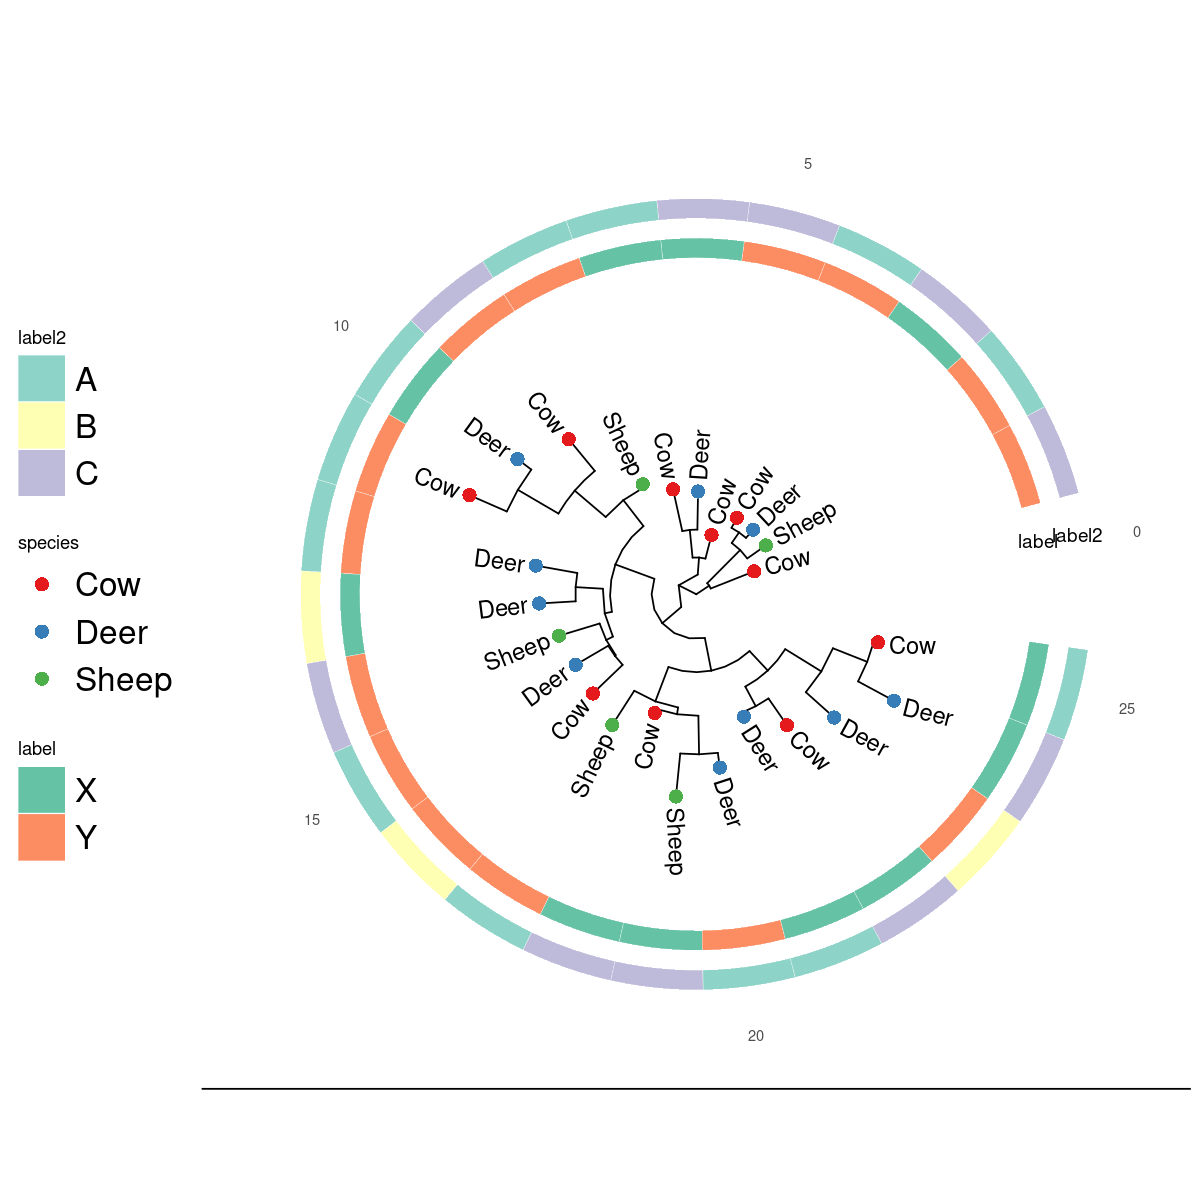

In [87]:
options(repr.plot.width=10, repr.plot.height=10)
ggplottree(tree, df, layout='c', cols=c('species','label','label2'),
           cmaps=c('Set1','Set2','Set3'), tipsize=4, 
           tiplabel=TRUE, tiplabelcol='species', tipoffset=.2, offset=.8 )

In [63]:
tree<-generate_tree(200)
df <- generate_metadata(tree$tip.label)
options(repr.plot.width=10, repr.plot.height=10)
ggplottree(tree, df, layout='cladogram', cols=c('species','country','label','label2'),
           cmaps=c('Set1','Set2','Set3',NULL), tipsize=2, offset=1 )

ERROR: Error in generate_tree(200): could not find function "generate_tree"


In [64]:
library(ape)
tree<-read.tree('temp.newick')
m<-read.table('blast_result.csv',header=TRUE,row.names=1,sep=',')

In [ ]:
options(repr.plot.width=12, repr.plot.height=8)
ggplottree(tree, m, layout='rect', tiplabel=TRUE, cols=c('species'), cmaps=c('Set1'),
           tiplabelcol='species', tipoffset=.001, tipsize=4, offset=.1) +xlim(NA,.07)